In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os

In [2]:
path_prefix = "/home/rei/tracelog"
path_tracelog = os.path.join(path_prefix, 'tracelog.txt')
path_start = os.path.join(path_prefix, 'callback_start.txt')
path_end = os.path.join(path_prefix, 'callback_end.txt')

path = path_tracelog
f = open(path)
f.close()
with open(path) as f:
    l = f.readlines()
    
S = l.index('Nodes:\n')
E = l.index('Publishers:\n')
no=[]
for i in l[S+3:E-1]:
    no.append(i.split()[4])

In [3]:
import os
dirname = "latency/"
os.makedirs(dirname, exist_ok=True)

#plot a label as ms
def label(latency):
    return 'max:{:.02f}ms, mean:{:.02f}ms'.format(max(latency),np.mean(latency))
#plot a graph as ms
def graph(latency, title):
    fig, ax = plt.subplots(1, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.hist(latency, bins=200, label=label(latency))
    plt.legend()
    plt.title("%s"%title, fontsize=15)
    plt.xlabel("Latency [ms]", fontsize=15)
    plt.ylabel("Sample", fontsize=15)
    filename = dirname + "%s"%title+".pdf"
    plt.savefig(filename)

#plot a label as us
def label2(latency):
    return 'max:{:.02f}us, mean:{:.02f}us'.format(max(latency),np.mean(latency))
#plot a graph
def graph2(latency, title):
    fig, ax = plt.subplots(1, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    plt.hist(latency, bins=200, label=label2(latency))
    plt.legend()
    plt.title("%s"%title, fontsize=15)
    plt.xlabel("Latency [us]", fontsize=15)
    plt.ylabel("Sample", fontsize=15)
    filename = dirname + "%s"%title+".pdf"
    plt.savefig(filename)

In [4]:
# get callback in XXX node
def cb(node):    
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    #node handle
    S = l.index('Nodes:\n')
    E = l.index('Publishers:\n')
    nodel = [line for line in l[S:E] if node in line]
    nodename= nodel[0].split()[4]
    nodeh= nodel[0].split()[0]

    S = l.index('Subscriptions:\n')
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    stopic=[]
    for i in subt:
        stopic.append('/'+i.split(' /')[1].split()[0])
    print('sub:',stopic)
    
    S = l.index('Publishers:\n')
    E = l.index('Subscriptions:\n')
    pubt = [line for line in l[S:E] if nodeh in line]
    ptopic=[]
    for i in pubt:
        ptopic.append('/'+i.split(' /')[1].split()[0])
    print('pub:',ptopic)
    
    S = l.index('Services:\n')
    E = l.index('Clients:\n')
    sert = [line for line in l[S:E] if nodeh in line]
    sname=[]
    for i in sert:
        sname.append('/'+i.split(' /')[1].split()[0])
    #print('service:',sname)
    
    S = l.index('Clients:\n')
    E = l.index('Timers:\n')
    clit = [line for line in l[S:E] if nodeh in line]
    csname=[]
    for i in clit:
        csname.append('/'+i.split(' /')[1].split()[0])
    #print('client:',csname)

def cbname(node,topic):
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #node handle
    S = l.index('Nodes:\n')
    E = l.index('Publishers:\n')
    node = [line for line in l[S:E] if node in line]
    nodename= node[0].split()[4]
    nodeh= node[0].split()[0]

    S = l.index('Subscriptions:\n')
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    st=[line for line in subt if topic in line]
    #print(st)
    subscription_handle=st[0].split()[0]
    
    #subscription_handle -> reference
    S = l.index('Subscription objects:\n')
    E = l.index('Services:\n')   
    refer=[]
    ref = [line for line in l[S:E] if subscription_handle in line]
    refer.append(''.join(ref))
    reference= refer[0].split()[0]
    
    #reference -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cboj=[]
    cb= [line for line in l[S:E] if reference in line]
    cboj.append(''.join(cb))
    callback_object=cboj[0].split()[2]
    cbh = str(hex(int(callback_object)))
    cbhandle = cbh.upper().replace('X', 'x')

    return cbhandle

# get callback duration
def cbd(node,topic):
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    #node handle
    S = l.index('Nodes:\n')
    E = l.index('Publishers:\n')
    node = [line for line in l[S:E] if node in line]
    nodename= node[0].split()[4]
    nodeh= node[0].split()[0]
    S = l.index('Subscriptions:\n')
    E = l.index('Subscription objects:\n')
    subt = [line for line in l[S:E] if nodeh in line]
    st=[line for line in subt if topic in line]
    subscription_handle= st[0].split()[0]
    
    #subscription_handle -> reference
    S = l.index('Subscription objects:\n')
    E = l.index('Services:\n')   
    refer=[]
    ref = [line for line in l[S:E] if subscription_handle in line]
    refer.append(''.join(ref))
    reference= refer[0].split()[0]
    
    #reference -> callback_object
    S = l.index('Callback objects:\n')
    E = l.index('Callback symbols:\n')   
    cboj=[]
    cb= [line for line in l[S:E] if reference in line]
    cboj.append(''.join(cb))
    callback_object=cboj[0].split()[2]

    t=[]
    S = l.index('Callback instances:\n')
    E = l.index('Lifecycle state machines:\n')  
    l_XXX = [line for line in l[S:E] if callback_object in line]

    cbd_ns = []
    for i in l_XXX:
        cbd_ns.append(int(i.split()[6].split('.')[1])) 
    cbd_us = []
    for i in cbd_ns:
        cbd_us.append(i/1000)
    
    for i in cbd_us:
        if i > 200000:
            cbd_us.remove(i)
            
    return cbd_us,nodename

def com_latency(callback1,callback2):
    path = path_end
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    com1_latency = []
    for i in l:
        cb1 = i.split("callback = ")[1].split(" }")[0]
        if (cb1 == callback1):
            com1 = int(i.split('+0.')[1].split(')')[0])
            com1_latency.append(com1)
            
    path = path_start
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    
    com2_latency = []
    for i in l:
        cb2 = i.split("callback = ")[1].split(",")[0]
        if (cb2 == callback2):
            com2 = int(i.split('+0.')[1].split(')')[0])
            com2_latency.append(com2)
    
    com_latency=[com1_latency[i]+com2_latency[i] for i in range(min(len(com1_latency),len(com2_latency)))]

    com_latency_us = []
    for i in com_latency:
        com_latency_us.append(i/1000)
    return com_latency_us

In [5]:
node1 = 'crop_box_filter_measurement_range'
node2 = 'voxel_grid_downsample_filter'
node3 = 'random_downsample_filter'
node4 = 'ndt_scan_matcher'
node5 = 'ekf_localizer'
node6 = 'stop_filter'
node7 = 'behavior_path_planner'
node8 = 'behavior_velocity_planner'
node9 = 'obstacle_avoidance_planner'
node10 = 'surround_obstacle_checker'
node11 = 'obstacle_stop_planner'
node12 = 'scenario_selector'
node13 = 'motion_velocity_smoother'
node14 = 'lateral_controller_node_exe'
node15 = 'latlon_muxer_node_exe'
node16 = 'vehicle_cmd_gate'

In [6]:
cb(node1)
cb(node2)
cb(node3)
cb(node4)
cb(node5)
cb(node6)
cb(node7)
cb(node8)
cb(node9)
cb(node10)
cb(node11)
cb(node12)
cb(node13)
cb(node14)
cb(node15)
cb(node16)

sub: ['/sensing/lidar/right_upper/rectified/pointcloud_ex']
pub: ['/rosout', '/parameter_events', '/localization/util/measurement_range/pointcloud', '/localization/util/crop_box_filter_measurement_range/crop_box_polygon']
sub: ['/localization/util/measurement_range/pointcloud']
pub: ['/rosout', '/parameter_events', '/localization/util/voxel_grid_downsample/pointcloud']
sub: ['/localization/util/voxel_grid_downsample/pointcloud']
pub: ['/rosout', '/parameter_events', '/localization/util/downsample/pointcloud']
sub: ['/localization/pose_twist_fusion_filter/pose_with_covariance_without_yawbias', '/map/pointcloud_map', '/localization/util/downsample/pointcloud']
pub: ['/rosout', '/parameter_events', '/tf', '/localization/pose_estimator/points_aligned', '/localization/pose_estimator/pose', '/localization/pose_estimator/pose_with_covariance', '/localization/pose_estimator/initial_pose_with_covariance', '/localization/pose_estimator/exe_time_ms', '/localization/pose_estimator/transform_probab

sub: ['/planning/scenario_planning/scenario_selector/trajectory', '/localization/kinematic_state', '/planning/scenario_planning/max_velocity']
pub: ['/rosout', '/parameter_events', '/planning/scenario_planning/trajectory', '/planning/scenario_planning/current_max_velocity', '/planning/scenario_planning/motion_velocity_smoother/distance_to_stopline', '/planning/scenario_planning/motion_velocity_smoother/stop_speed_exceeded', '/planning/scenario_planning/motion_velocity_smoother/closest_velocity', '/planning/scenario_planning/motion_velocity_smoother/closest_acceleration', '/planning/scenario_planning/motion_velocity_smoother/closest_jerk', '/planning/scenario_planning/motion_velocity_smoother/closest_max_velocity', '/planning/scenario_planning/motion_velocity_smoother/calculation_time', '/planning/scenario_planning/motion_velocity_smoother/debug/trajectory_raw', '/planning/scenario_planning/motion_velocity_smoother/debug/trajectory_external_velocity_limited', '/planning/scenario_plannin

In [7]:
topic1 = '/sensing/lidar/right_upper/rectified/pointcloud_ex'
topic2 = '/localization/util/measurement_range/pointcloud'
topic3 = '/localization/util/voxel_grid_downsample/pointcloud'
topic4 = '/localization/util/downsample/pointcloud'
topic5 = '/localization/pose_estimator/pose_with_covariance'
topic6 = '/localization/pose_twist_fusion_filter/kinematic_state'
topic7 = '/localization/kinematic_state'
topic8 = '/planning/scenario_planning/lane_driving/behavior_planning/path_with_lane_id'
topic9 = '/planning/scenario_planning/lane_driving/behavior_planning/path'
topic10 = '/planning/scenario_planning/lane_driving/motion_planning/obstacle_avoidance_planner/trajectory'
topic11 = '/planning/scenario_planning/lane_driving/motion_planning/surround_obstacle_checker/trajectory'
topic12 = '/planning/scenario_planning/lane_driving/trajectory'
topic13 = '/planning/scenario_planning/scenario_selector/trajectory'
topic14 = '/planning/scenario_planning/trajectory'
topic15 = '/control/trajectory_follower/lateral/control_cmd'
topic16 = '/control/trajectory_follower/control_cmd'

In [8]:
cb1 = cbname(node1,topic1)
cb2 = cbname(node2,topic2)
cb3 = cbname(node3,topic3)
cb4 = cbname(node4,topic4)
cb5 = cbname(node5,topic5)
cb6 = cbname(node6,topic6)
cb7 = cbname(node7,topic7)
cb8 = cbname(node8,topic8)
cb9 = cbname(node9,topic9)
cb10 = cbname(node10,topic10)
cb11 = cbname(node11,topic11)
cb12 = cbname(node12,topic12)
cb13 = cbname(node13,topic13)
cb14 = cbname(node14,topic14)
cb15 = cbname(node15,topic15)
cb16 = cbname(node16,topic16)

753

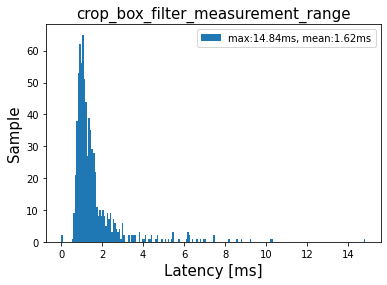

In [9]:
cbduration1,title = cbd(node1,topic1)
cbduration1_ms=[i/1000 for i in cbduration1]
graph(cbduration1_ms,title)
len(cbduration1)

753

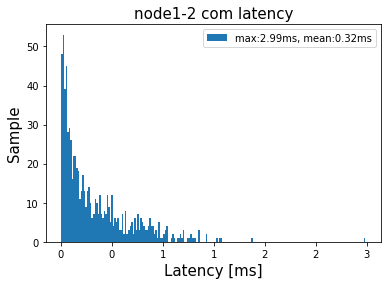

In [10]:
comlatency12=com_latency(cb1,cb2)
title='node1-2 com latency'
comlatency12_ms=[i/1000 for i in comlatency12]
graph(comlatency12_ms,title)
len(comlatency12)

753

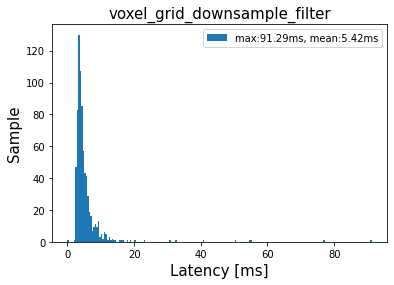

In [11]:
cbduration2,title = cbd(node2,topic2)
cbduration2_ms=[i/1000 for i in cbduration2]
graph(cbduration2_ms,title)
len(cbduration2)

753

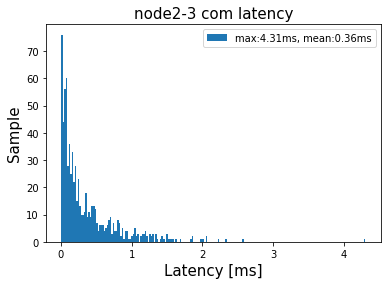

In [12]:
comlatency23=com_latency(cb2,cb3)
comlatency23_ms=[i/1000 for i in comlatency23]
title='node2-3 com latency'
graph(comlatency23_ms,title)
len(comlatency23)

753

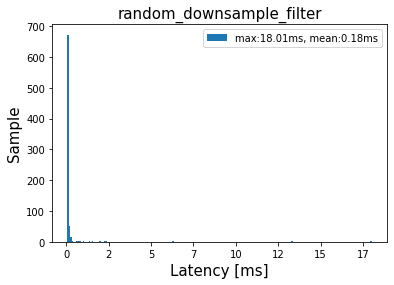

In [13]:
cbduration3,title = cbd(node3,topic3)
cbduration3_ms=[i/1000 for i in cbduration3]
graph(cbduration3_ms,title)
len(cbduration3)

718

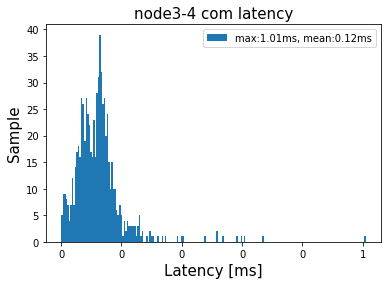

In [14]:
comlatency34=com_latency(cb3,cb4)
title='node3-4 com latency'
comlatency34_ms=[i/1000 for i in comlatency34]
graph(comlatency34_ms,title)
len(comlatency34)

717

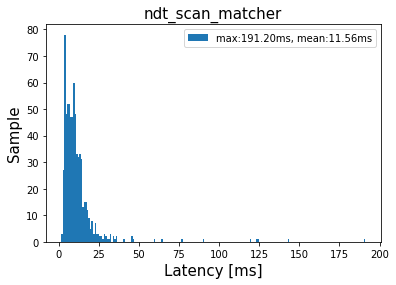

In [15]:
cbduration4,title = cbd(node4,topic4)
cbduration4_ms=[i/1000 for i in cbduration4]
graph(cbduration4_ms,title)
len(cbduration4)

713

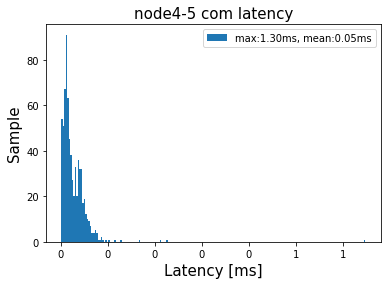

In [16]:
comlatency45=com_latency(cb4,cb5)
title='node4-5 com latency'
comlatency45_ms=[i/1000 for i in comlatency45]
graph(comlatency45_ms,title)
len(comlatency45)

713

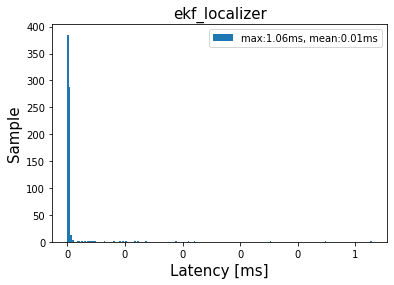

In [17]:
cbduration5,title = cbd(node5,topic5)
cbduration5_ms=[i/1000 for i in cbduration5]
graph(cbduration5_ms,title)
len(cbduration5)

713

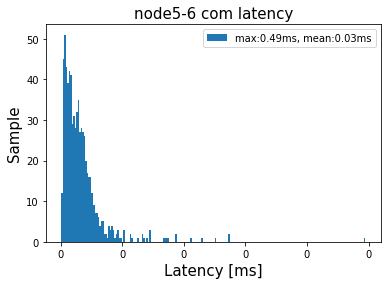

In [18]:
comlatency56=com_latency(cb5,cb6)
title='node5-6 com latency'
comlatency56_ms=[i/1000 for i in comlatency56]
graph(comlatency56_ms,title)
len(comlatency56)

3776

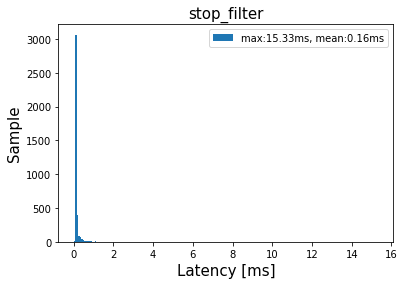

In [19]:
cbduration6,title = cbd(node6,topic6)
cbduration6_ms=[i/1000 for i in cbduration6]
graph(cbduration6_ms,title)
len(cbduration6)

3721

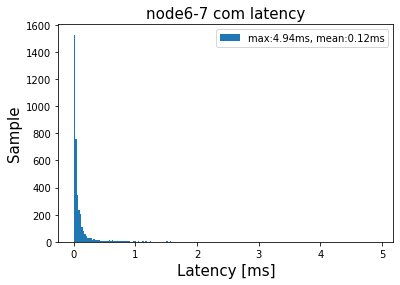

In [20]:
comlatency67=com_latency(cb6,cb7)
title='node6-7 com latency'
comlatency67_ms=[i/1000 for i in comlatency67]
graph(comlatency67_ms,title)
len(comlatency67)

3721

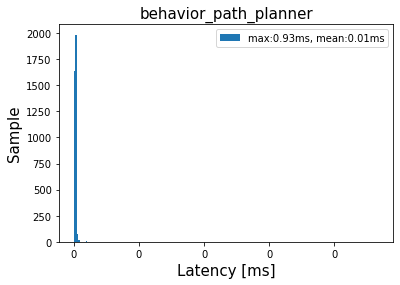

In [21]:
cbduration7,title = cbd(node7,topic7)
cbduration7_ms=[i/1000 for i in cbduration7]
graph(cbduration7_ms,title)
len(cbduration7)

638

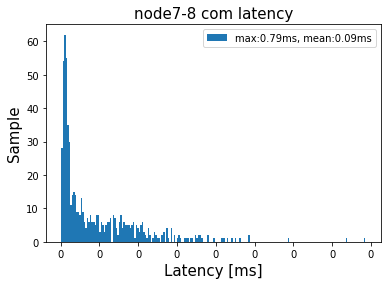

In [22]:
comlatency78=com_latency(cb7,cb8)
title='node7-8 com latency'
comlatency78_ms=[i/1000 for i in comlatency78]
graph(comlatency78_ms,title)
len(comlatency78)

636

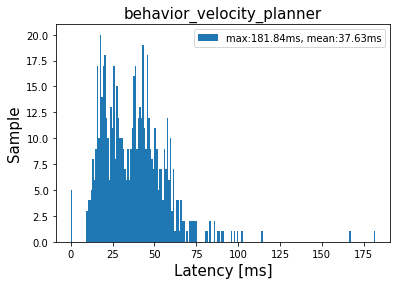

In [23]:
cbduration8,title = cbd(node8,topic8)
cbduration8_ms=[i/1000 for i in cbduration8]
graph(cbduration8_ms,title)
len(cbduration8)

619

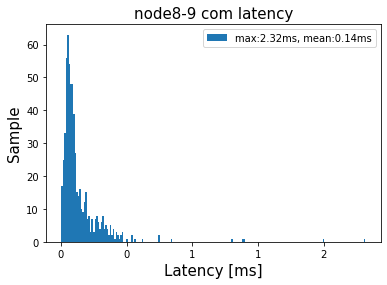

In [24]:
comlatency89=com_latency(cb8,cb9)
title='node8-9 com latency'
comlatency89_ms=[i/1000 for i in comlatency89]
graph(comlatency89_ms,title)
len(comlatency89)

610

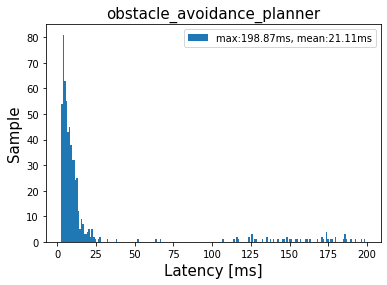

In [25]:
cbduration9,title = cbd(node9,topic9)
cbduration9_ms=[i/1000 for i in cbduration9]
graph(cbduration9_ms,title)
len(cbduration9)

617

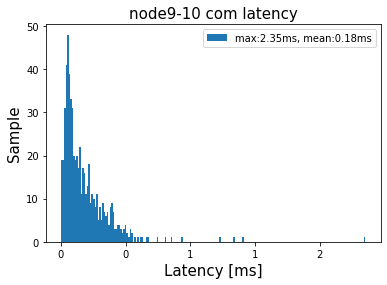

In [26]:
comlatency910=com_latency(cb9,cb10)
title='node9-10 com latency'
comlatency910_ms=[i/1000 for i in comlatency910]
graph(comlatency910_ms,title)
len(comlatency910)

616

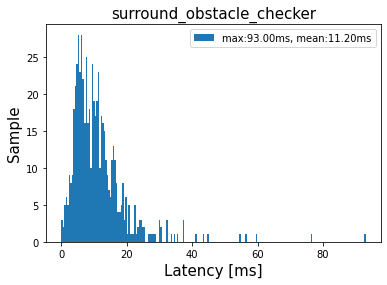

In [27]:
cbduration10,title = cbd(node10,topic10)
cbduration10_ms=[i/1000 for i in cbduration10]
graph(cbduration10_ms,title)
len(cbduration10)

606

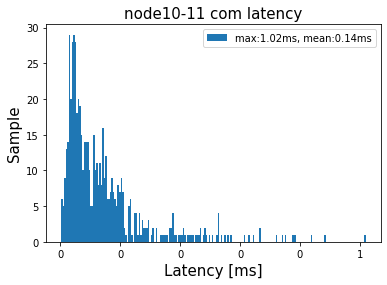

In [28]:
comlatency1011=com_latency(cb10,cb11)
title='node10-11 com latency'
comlatency1011_ms=[i/1000 for i in comlatency1011]
graph(comlatency1011_ms,title)
len(comlatency1011_ms)

606

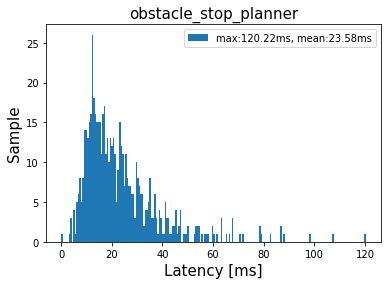

In [29]:
cbduration11,title = cbd(node11,topic11)
cbduration11_ms=[i/1000 for i in cbduration11]
graph(cbduration11_ms,title)
len(cbduration11)

606

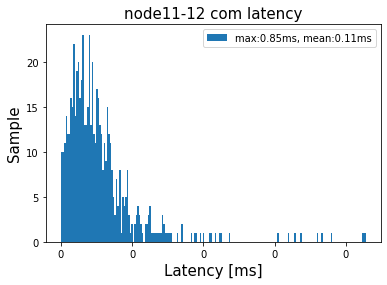

In [30]:
comlatency1112=com_latency(cb11,cb12)
title='node11-12 com latency'
comlatency1112_ms=[i/1000 for i in comlatency1112]
graph(comlatency1112_ms,title)
len(comlatency1112)

606

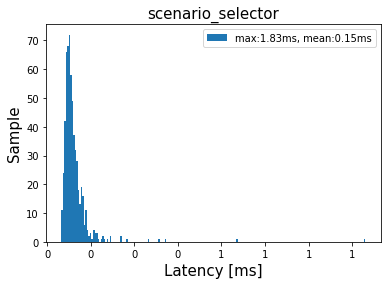

In [31]:
cbduration12,title = cbd(node12,topic12)
cbduration12_ms=[i/1000 for i in cbduration12]
graph(cbduration12_ms,title)
len(cbduration12)

606

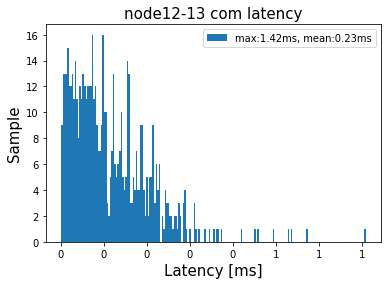

In [32]:
comlatency1213=com_latency(cb12,cb13)
title='node12-13 com latency'
comlatency1213_ms=[i/1000 for i in comlatency1213]
graph(comlatency1213_ms,title)
len(comlatency1213)

606

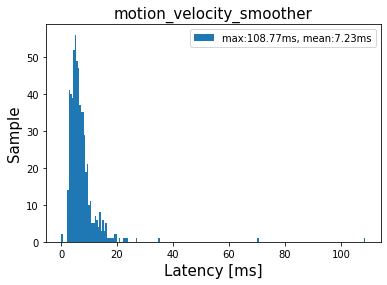

In [33]:
cbduration13,title = cbd(node13,topic13)
cbduration13_ms=[i/1000 for i in cbduration13]
graph(cbduration13_ms,title)
len(cbduration13)

606

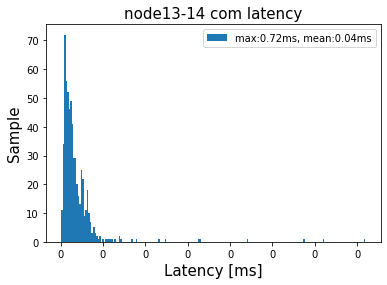

In [34]:
comlatency1314=com_latency(cb13,cb14)
title='node13-14 com latency'
comlatency1314_ms=[i/1000 for i in comlatency1314]
graph(comlatency1314_ms,title)
len(comlatency1314)

606

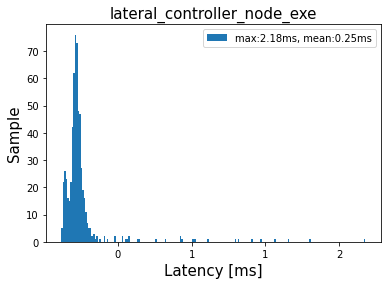

In [35]:
cbduration14,title = cbd(node14,topic14)
cbduration14_ms=[i/1000 for i in cbduration14]
graph(cbduration14_ms,title)
len(cbduration14)

606

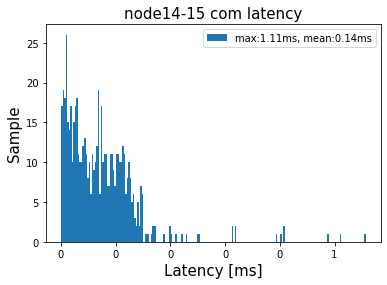

In [36]:
comlatency1415=com_latency(cb14,cb15)
title='node14-15 com latency'
comlatency1415_ms=[i/1000 for i in comlatency1415]
graph(comlatency1415_ms,title)
len(comlatency1415)

2101

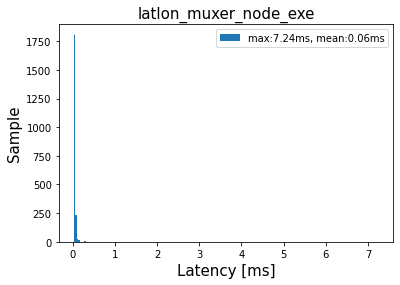

In [37]:
cbduration15,title = cbd(node15,topic15)
cbduration15_ms=[i/1000 for i in cbduration15]
graph(cbduration15_ms,title)
len(cbduration15)

2101

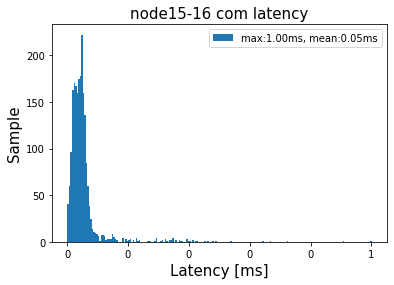

In [38]:
comlatency1516=com_latency(cb15,cb16)
title='node15-16 com latency'
comlatency1516_ms=[i/1000 for i in comlatency1516]
graph(comlatency1516_ms,title)
len(comlatency1516)

3891

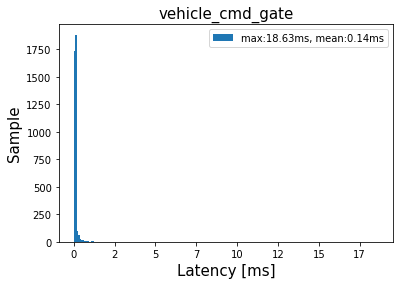

In [39]:
cbduration16,title = cbd(node16,topic16)
cbduration16_ms=[i/1000 for i in cbduration16]
graph(cbduration16_ms,title)
len(cbduration16)

In [40]:
n1 = [int(cbduration1[i]+cbduration2[i]+cbduration3[i]+cbduration4[i]+cbduration5[i]+cbduration8[i]+cbduration9[i]+cbduration10[i]+cbduration11[i]+cbduration12[i]+cbduration13[i]+cbduration14[i]+cbduration15[i]) for i in range(min(len(cbduration1),len(cbduration2),len(cbduration3),len(cbduration4),len(cbduration5),len(cbduration8),len(cbduration9),len(cbduration10),len(cbduration11),len(cbduration12),len(cbduration13),len(cbduration14),len(cbduration15)))]
c1 = [int(comlatency12[i]+comlatency23[i]+comlatency34[i]+comlatency45[i]+comlatency56[i]+comlatency78[i]+comlatency89[i]+comlatency910[i]+comlatency1011[i]+comlatency1112[i]+comlatency1213[i]+comlatency1314[i]+comlatency1415[i]+comlatency1516[i]) for i in range(min(len(comlatency12),len(comlatency23),len(comlatency34),len(comlatency45),len(comlatency56),len(comlatency78),len(comlatency89),len(comlatency910),len(comlatency1011),len(comlatency1112),len(comlatency1213),len(comlatency1314),len(comlatency1415),len(comlatency1516)))]
p1 = [int(n1[i]+c1[i]) for i in range(min(len(n1),len(c1)))]

n2 = [int(cbduration6[i]+cbduration7[i]+cbduration16[i]) for i in range(min(len(cbduration6),len(cbduration7),len(cbduration16)))]
c2 = [int(comlatency67[i]) for i in range(len(comlatency67))]
p2 = [int(n2[i]+c2[i]) for i in range(min(len(n2),len(c2)))]

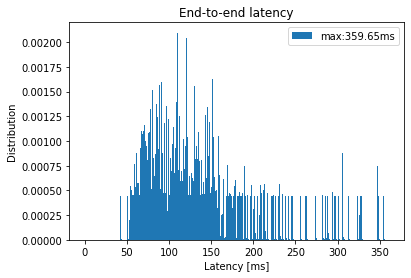

In [41]:
# convolution integral
import numpy as np
import matplotlib.pyplot as plt
def convo(p1,p2):
    bin=50
    x1= np.arange(bin,max(p1)+bin,bin)
    #print(x1,len(x1))
    x2= np.arange(bin,max(p2)+bin,bin)
    #print(x2,len(x2))
    if len(x1) > len(x2):
        x=x1
    else:
        x=x2
    
    #P1
    P1=[]
    for i in x:
        l=0
        for j in p1:
            if (j < i)&(j > i-bin):
                l+=1
        l/= len(p1)
        P1.append(l)

    #P2
    P2=[]
    for i in x:
        l=0
        for j in p2:
            if (j < i)&(j > i-bin):
                l+=1
        l/= len(p2)
        P2.append(l)
    
    #P1+P2
    P = [] 
    for i in range(len(x)):
        p12 = 0
        for t in range(i):
            p12+= P1[t]*(P2[i-t] + P2[i-t-1])/2.0        
        P.append(p12)
    return x,P

x,p=convo(p1,p2)
x_ms=[i/1000 for i in x]
m=[]
j=0
for i in p:
    j+=50
    if i > 0:
        m.append(j)
maxinum=max(m)/1000

fig, ax = plt.subplots(1, 1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('End-to-end latency')
plt.xlabel('Latency [ms]')
plt.ylabel('Distribution')
plt.bar(x_ms,p,label='max:{:.02f}ms'.format(maxinum))
plt.legend()
filename = dirname + "e2elatency.pdf"
plt.savefig(filename)

In [42]:
# a=0
# for i in p:
#     a+=i
# r=int(100000/50)
# k=0
# for i in range(r):
#     k+=p[i]
# k/a

In [43]:
#service pair
def pair():
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    S = l.index('Services:\n')
    E = l.index('Clients:\n')
    service_sn=[]
    for i in l[S+3:E-1]:
        service_sn.append(i.split()[4])
    #print(set(service_sn))
    
    path = path_tracelog
    f = open(path)
    f.close()
    with open(path) as f:
        l = f.readlines()
    S = l.index('Clients:\n')
    E = l.index('Timers:\n')
    client_sn=[]
    for i in l[S+3:E-1]:
        client_sn.append(i.split()[4])
    #print(set(client_sn))
    
    for i in service_sn:
        for j in client_sn:
            if i == j:
                print(i)
pair()

/pointcloud_container/_container/load_node
/pointcloud_container/_container/load_node
/pointcloud_container/_container/load_node
/gsm8/socket_can_receiver/change_state
/system/system_monitor/system_monitor/system_monitor_container/_container/load_node
/gsm8/socket_can_sender/change_state
/map/map_container/_container/load_node
/sensing/lidar/front_lower/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/front_lower/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/rear_upper/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/rear_upper/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/left_upper/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/left_upper/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/right_upper/pointcloud_preprocessor/pandar_node_container/_container/load_node
/sensing/lidar/ri

In [44]:
#service latency
client_req = 837111312
service_req= 837568907
service_res= 837667763
client_res = 839947678

requestlatency=(service_req-client_req)/1000000
servicecallback=(service_res-service_req)/1000000
responselatency=(client_res-service_res)/1000000
servicelatency=requestlatency+servicecallback+responselatency
print(requestlatency,'ms')
print(servicecallback,'ms')
print(responselatency,'ms')
print(servicelatency,'ms')

0.457595 ms
0.098856 ms
2.279915 ms
2.836366 ms
